In [1]:
from tensorflow.keras import backend as K
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Input, Dense, Lambda,Conv1D,Conv2DTranspose, LeakyReLU,Activation,Flatten,Reshape
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import load_model
import emcee
import warnings
warnings.filterwarnings('ignore')

2025-07-28 14:53:31.692352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-28 14:53:31.996379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753714412.122518   28641 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753714412.160018   28641 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753714412.451579   28641 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
JV_raw = np.loadtxt("/mnt/c/Users/pssrg/Downloads/GaAs_sim_nJV.txt")
par = np.loadtxt("/mnt/c/Users/pssrg/Downloads/GaAs_sim_label.txt")

In [3]:
print(JV_raw.shape)
print(par.shape)

(19999, 500)
(19999, 5)


In [4]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides ):
    
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1),padding='SAME')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#Covert labels from log10 form to log
        
def log10_ln(x):
    return np.log(np.power(10,x))

par = log10_ln(par)


#Data normalization for the whole JV dataset

def min_max(x):
    min = np.min(x)
    max = np.max(x)
    return (x-min)/(max-min),max,min

#Normalize raw JV data

JV_norm,JV_max,JV_min = min_max(JV_raw)

#Normalize JV descriptors column-wise
scaler = MinMaxScaler()

par_n = scaler.fit_transform(par)   

#create training and testing datset

X_train, X_test, y_train, y_test = train_test_split(JV_norm,par_n, test_size=0.2)

#add in Gaussian noise to train the denoising Autoencoder

X_train_nos = X_train+0.002 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 

X_test_nos = X_test+0.002 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

Text(0, 0.5, 'current(a.u.)')

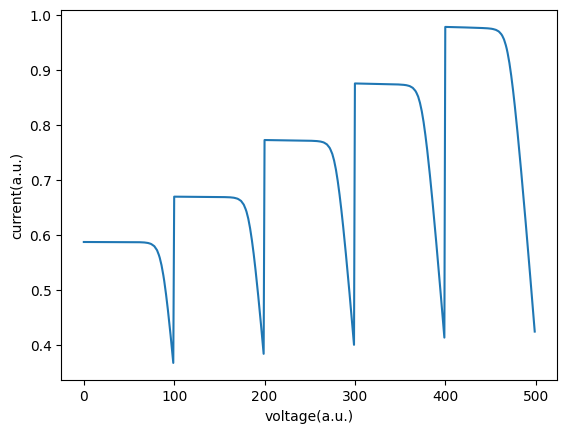

In [5]:
plt.plot(X_train[0,:])
plt.xlabel('voltage(a.u.)')
plt.ylabel('current(a.u.)')

In [6]:
input_dim = X_train.shape[1]
label_dim = y_train.shape[1]

max_filter = 256
strides = [5, 2, 2]
kernel = [7, 5, 3]
batch_size = 128
x = Input(shape=(input_dim,))  # JVi (noisy input)

def encoder(x):
    x = Lambda(lambda x: K.expand_dims(x, axis=2), output_shape=lambda s: (s[0], s[1], 1))(x)
    en0 = Conv1D(max_filter // 4, kernel[0], strides=strides[0], padding='same')(x)
    en0 = LeakyReLU(0.2)(en0)
    en1 = Conv1D(max_filter // 2, kernel[1], strides=strides[1], padding='same')(en0)
    en1 = LeakyReLU(0.2)(en1)
    en2 = Conv1D(max_filter, kernel[2], strides=strides[2], padding='same')(en1)
    en2 = LeakyReLU(0.2)(en2)
    en3 = Flatten()(en2)
    en3 = Dense(100, activation='relu')(en3)
    z = Dense(label_dim, activation='linear')(en3)
    return z

z = encoder(x)
encoder_model = Model(x, z)
map_size = K.int_shape(encoder_model.layers[-4].output)[1]  # From last Conv1D

# ----------- Decoder -----------
z1 = Dense(100, activation='relu')(z)
z1 = Dense(max_filter * map_size, activation='relu')(z1)
z1 = Reshape((map_size, 1, max_filter))(z1)
z2 = Conv2DTranspose(max_filter // 2, (kernel[2], 1), strides=(strides[2], 1), padding='same')(z1)
z2 = Activation('relu')(z2)
z3 = Conv2DTranspose(max_filter // 4, (kernel[1], 1), strides=(strides[1], 1), padding='same')(z2)
z3 = Activation('relu')(z3)
z4 = Conv2DTranspose(1, (kernel[0], 1), strides=(strides[0], 1), padding='same')(z3)
decoded_x = Activation('sigmoid')(z4)
decoded_x = Lambda(lambda x: K.squeeze(x, axis=2), output_shape=lambda s: (s[0], s[1], s[3]))(decoded_x)
decoded_x = Lambda(lambda x: K.squeeze(x, axis=2), output_shape=lambda s: (s[0], s[1]))(decoded_x)

# Denoising Autoencoder Model
ae = Model(inputs=x, outputs=decoded_x)

# ----------- Loss Function -----------
def ae_loss(x_true, x_pred):
    return K.mean(K.sum(K.square(x_true - x_pred), axis=-1))

ae.compile(optimizer='adam', loss=ae_loss)

# Reduce learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

# ----------- Train Autoencoder -----------
ae.fit(
    X_train_nos,
    X_train,
    shuffle=True,
    batch_size=batch_size,
    epochs=50,
    validation_split=0.0,
    callbacks=[reduce_lr]
)


I0000 00:00:1753714419.505374   28641 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


I0000 00:00:1753714427.353320   28758 service.cc:152] XLA service 0x7f17640140b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753714427.353614   28758 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-28 14:53:47.438161: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753714427.783937   28758 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-28 14:53:49.034727: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_881', 76 bytes spill stores, 92 bytes spill loads

2025-07-28 14:53:49.036491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.8250   

I0000 00:00:1753714440.831502   28758 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1744

2025-07-28 14:54:02.480016: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_531', 4 bytes spill stores, 4 bytes spill loads

2025-07-28 14:54:02.616972: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_542', 240 bytes spill stores, 240 bytes spill loads

2025-07-28 14:54:03.074129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_542', 464 bytes spill stores, 464 bytes spill loads

2025-07-28 14:54:03.149784: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_542', 24 bytes spill stores, 24 bytes spill loads

2025-07-28 14:54:03.382226: I external/loc

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 7.5419 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6008 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1175 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1026 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0866 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0708 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - learning_rate: 0.0010
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - learning_rate: 0.0010
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - learning_rate: 0.0010
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - learning_rate: 0.0010
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 

2025-07-28 14:54:29.854845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_95', 20 bytes spill stores, 20 bytes spill loads



125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


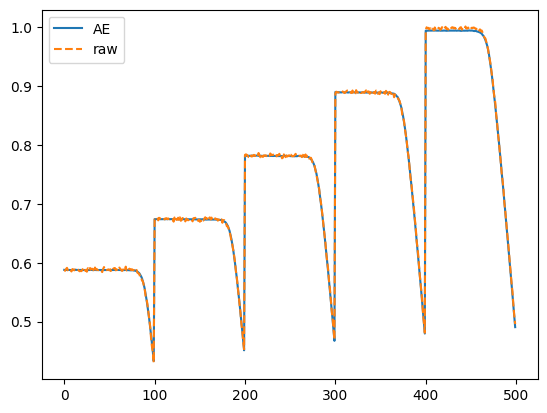

In [7]:
x_test_decoded= ae.predict(X_test_nos)
rand_ind = np.random.randint(0,100)
plt.plot(x_test_decoded[rand_ind,:],label='AE')
plt.plot(X_test_nos[rand_ind,:],'--',label='raw')
plt.legend()
plt.show()

In [9]:
ae.save('./Trained_Models/Denoiser.keras')